**ECG Beat Classification with a 1D-CNN in PyTorch**

Download ECG Heartbeat dataset from Kaggle

In [2]:
from google.colab import files
files.upload() # Upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


Load data and plot a couple of examples

(87554, 188)
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  

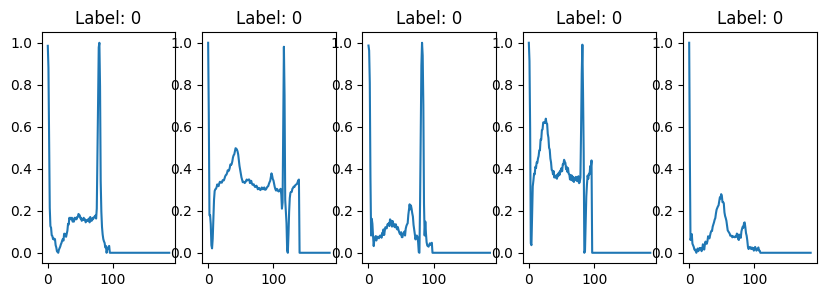

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('mitbih_train.csv', header=None)

# Sanity check dataset
print(df.shape)
print(df.head())

# Plot a few examples
examples = 5
fig, axs = plt.subplots(1, examples, figsize=(10, 2))
for i in range(examples):
  axs[i].plot(df.iloc[i, :-1])
  axs[i].set_title(f'Label: {int(df.iloc[i, -1])}')
plt.show()

Preprocessing data - making the data binary between normal (0) and abnormal (all others) for easier training. Then splitting into test and train sets.

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

# Features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Make it binary: Normal (0) vs Abnormal (all others)
y = np.where(y == 0, 0, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (70043, 187), Test size: (17511, 187)


Build PyTorch Dataset and Dataloader

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]  # Add channel dim

train_ds = ECGDataset(X_train, y_train)
test_ds = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

Build 1D-CNN Model

In [13]:
import torch.nn as nn

class ECGClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

model = ECGClassifier()

Train the model

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):  # small number of epochs for quick project
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.3977
Epoch 2, Loss: 0.2882
Epoch 3, Loss: 0.2735
Epoch 4, Loss: 0.2659
Epoch 5, Loss: 0.2591


Evaluate the model

ROC-AUC: 0.894
Sensitivity: 0.633, Specificity: 0.975


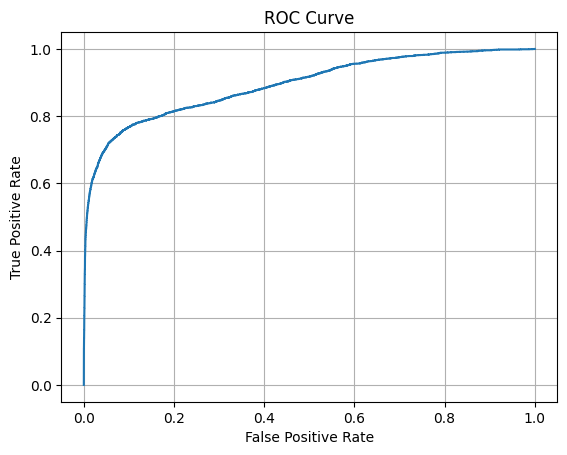

In [15]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

model.eval()
y_true, y_scores = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        probs = preds.softmax(dim=1)[:, 1]
        y_true.extend(yb.tolist())
        y_scores.extend(probs.tolist())

# Metrics
auc = roc_auc_score(y_true, y_scores)
print(f"ROC-AUC: {auc:.3f}")

# Confusion matrix
y_pred = [1 if p > 0.5 else 0 for p in y_scores]
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()
